# Traffic Simulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import copy

In [30]:
class TrafficSimulation():

    def __init__(self, car_density, num_lanes, road_length=50, p_slow=0.2, max_vel=5,  p_change_lanes=0.75):
        '''
        Create a new traffic simulation object by distributing cars randomly
        along the road, each with a random velocity.

        Arguments:
            car_density (float) The fraction of cells that have a car.
            
            num_lanes (int) The number of lanes. For this model, Default: 1 or 2.
            
            road_length (int) The number of cells in the road. 
              Default: 50.

            p_slow (float) The probability that a car will randomly
              slow down by 1 during an update step. 
              Default: 0.2.

            max_vel (int) The maximum speed of any car.
              Default: 5.
              
            p_change_lanes (float) The probability that a car will change lanes,
              given they meet all other conditions. 
              Default: 0.75
        '''
        self.car_density = car_density
        self.num_lanes = num_lanes
        self.road_length = road_length
        self.p_slow = p_slow
        self.max_vel = max_vel
        self.p_change_lanes = p_change_lanes
        
        num_cars = int(round(car_density * road_length))
        car_positions = scipy.random.choice(
            range(self.road_length), 
            size=(num_lanes, num_cars))
        
        self.current_state = -scipy.ones((self.num_lanes, self.road_length), dtype=int)
        for lane in range(self.num_lanes):
            self.current_state[lane, car_positions[lane]]= scipy.random.randint(0, 
                                                                                1 + max_vel, 
                                                                                size = (num_cars))

        self.time_step = 0
        self.traffic_flow = 0.
        
    def lane_change(self):
        '''
        Cars switch lanes where eligible – dependent on cars in front in the same lane,
        cars in front in the other lane, and cars behind in the other lane. 
        '''
        for lane in range(self.num_lanes):  #for each lane
            for position in range(self.road_length):
                if self.current_state[lane, position] != -1:
                    d_ahead = 1
                    d_ahead_other = 1
                    d_behind_other = 1
                    while self.current_state[lane, (position + d_ahead) % self.road_length] == -1:
                        d_ahead += 1
                    while self.current_state[1 - lane, (position + d_ahead_other) % self.road_length] == -1:
                        d_ahead_other += 1
                    while self.current_state[1 - lane, (position - d_behind_other) % self.road_length] == -1:
                        d_behind_other += 1
                    
                    if d_ahead < self.current_state[lane, position] + 1:  
                        if self.current_state[lane - 1, position] == -1:
                            if d_ahead_other > self.current_state[lane, position] + 1: 
                                if d_behind_other > self.max_vel: 
                                    if scipy.random.uniform(0, 1) < self.p_change_lanes: 
                                        self.current_state[lane - 1, position] = self.current_state[lane, position]
                                        self.current_state[lane, position] = -1

    
    def update(self):
        ''' 
        Update the car position and velocity by advancing one time step.
        '''
        if self.num_lanes > 1:
            self.lane_change()
            
        for lane in range(self.num_lanes):
            for position in range(self.road_length):
                if self.current_state[lane, position] != -1:
                    distance = 1  # The number of empty cells between this car and the next plus 1
                    while self.current_state[lane, (position + distance) % self.road_length] == -1:
                        distance += 1
                    # Accelerate 
                    if self.current_state[lane, position] < self.max_vel:
                        self.current_state[lane, position] += 1
                    # Decelerate
                    if distance <= self.current_state[lane, position]:
                        self.current_state[lane, position] = distance - 1
                    # Slow Down
                    if (self.current_state[lane, position] > 0) and (scipy.random.uniform(0, 1) < self.p_slow):
                        self.current_state[lane, position] -= 1

        next_state = -scipy.ones((self.num_lanes, self.road_length), dtype=int)

        for lane in range(self.num_lanes):
            for position in range(self.road_length):
                if self.current_state[lane, position] != -1:
                    next_state[lane, (position + self.current_state[lane, position]) % self.road_length] = self.current_state[lane, position]
            self.current_state[lane] = next_state[lane]

        self.time_step += 1
        for lane in range(self.num_lanes):
            for position in range(self.max_vel):
                if self.current_state[lane, position] > position:
                    self.traffic_flow += 1

        self.average_traffic_flow = self.traffic_flow / self.time_step

        
    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        for lane in range(self.num_lanes):
            print(''.join('.' if x == -1 else str(x) for x in self.current_state[lane]))

        if self.num_lanes > 1:
            print "\n"

## Running the Simulation

In [59]:
def run_simulation(car_density, num_lanes, num_sims):
    '''
    Run the simulation. 
    
    Arguments:
        car_density (float) The fraction of cells that have a car.
        
        num_lanes (int) The number of lanes. Default: 1 or 2. 
        
        num_sims (int) The number of times to run the simulation. 
        
    Outputs:
        Average traffic flow (float) The traffic flow (number of cars passing 
          the periodic boundary condition) averaged for a specific set of paramters. 
    '''
    sim = TrafficSimulation(car_density = car_density, num_lanes = num_lanes)
    sim.display()
    for x in range(num_sims):
        sim.update()
        sim.display()
    print('Traffic density:', sim.car_density)
    print('Average traffic flow:', sim.traffic_flow / sim.time_step)
    

## Visualizing the Output
### Flow Rates for Varying Densities

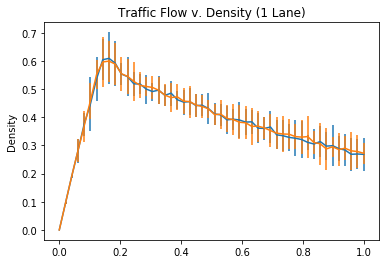

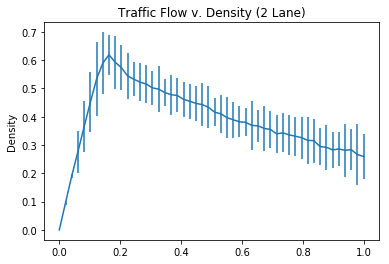

In [71]:
def visualizations(densities, number_lanes):
    '''
    Visualize the output of the model as the relationship between density and 
    average flow rate. 
    '''
    mean_flows = []
    std_flows = []

    for dens in densities:
        flows = []
        for j in range(20):
            sim = TrafficSimulation(car_density=dens, num_lanes=number_lanes)
            for i in range(200):
                    sim.update()
            avg_flow = sim.traffic_flow / float(sim.time_step)
            flows.append(avg_flow)
        mean_flows.append(np.mean(flows) / float(number_lanes))
        std_flows.append(np.std(flows))
    
    plt.errorbar(scipy.linspace(0,1,50), mean_flows, xerr=0, yerr= 1.96*np.array(std_flows))
    plt.title('Traffic Flow v. Density ({} Lane)'.format(number_lanes))
    plt.ylabel('Density')
    plt.show()

visualizations(np.linspace(0, 1, 50), 1)
visualizations(np.linspace(0, 1, 50), 2)

### Visualizing the State of the Model Over Time

In [60]:
print("Figure 1")
print("Single Lane Traffic Simulation (Density: 0.1)")
run_simulation(0.1, 1, 20)
print("\n")
print("Single Lane Traffic Simulation (Density: 0.5)")
run_simulation(0.5, 1, 20)
print("\n")
print("Single Lane Traffic Simulation (Density: 0.9)")
run_simulation(0.9, 1, 20)

Figure 1
Single Lane Traffic Simulation (Density: 0.1)
......1.....5...................3..0.............4
....5...2........5................2.1.............
.......3..2...........5............1..2...........
.........2...3.............5.........2..2.........
............3....4..............5.....1....3......
................4.....5..............5..2......4..
..5..................5.....5..........1....3......
.......5.................4......5.......2......4..
..5.........5................4.......5.....3......
.......5........4................4........5....4..
..5.........5.......4.................5.......4...
4.....4..........5......4..................5......
.....5.....5..........5......5.................4..
..5.......5.....5.........4.......5...............
.......5.......5....4..........5......4...........
............5......4.....5..........5......5......
................4.......5.....5.........4.......5.
...5.................5......4......5.........5....
5.......5.................5

In [68]:
print("Double Lane Traffic Simulation (Density: 0.1)")
run_simulation(0.1, 2, 10)
print("\n")
print("Double Lane Traffic Simulation (Density: 0.5)")
run_simulation(0.5, 2, 10)
print("\n")
print("Double Lane Traffic Simulation (Density: 0.9)")
run_simulation(0.9, 2, 10)

Double Lane Traffic Simulation (Density: 0.1)
..........5.....0......1....................33....
.......................4..3........4...4...5......


..............4..1......1...............5...0....4
........................1.....4...........3.....5.


....5..............2......2...............2..1....
...5...............5......2........5.........3....


.........5...........2.......3..............2..2..
........5...............5....3.........4.........4


3.............5.........3........4............2...
....5........5..............4....4..........5.....


....4..............5........4........4...........3
.........5........5.............4....4...........5


...4.....5..............5........5........5.......
....5........4.........5............4.....5.......


........5.....5..............5........5.......4...
.........5........5........4.............5.....5..


4............5.....5..............5.......4.......
..5..........4.........5........5.............5...


.....5...........4